In [2]:
import ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.colors import ListedColormap
import math

df = pd.read_csv("Cleaned_DF.csv")

In [3]:
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
mask1 = (df['CryoSleep']==0)&(df['Age']>12.5)
features = ['Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Deck','Num','Side','route']
dz = df[mask1][features+["Transported"]]
dz.shape

(4447, 12)

MV 0: [-5.3163e-03  1.5682e-04  1.0700e-01 -1.6002e-01 -1.1772e-01  1.0652e-01
  9.5508e-02  5.1048e-02  2.4304e-02 -7.8162e-02 -3.3554e-02]

MV 1: [-5.3163e-03  1.5682e-04  1.0700e-01 -1.6002e-01 -1.1772e-01  1.0652e-01
  9.5508e-02  5.1048e-02  2.4304e-02 -7.8162e-02 -3.3554e-02]

Собственные значения в порядке убывания:

72.73116159903168
4.45333431583576e-15
3.8102670217192735e-15
2.415513101848506e-15
2.199530759326407e-15
2.199530759326407e-15
1.5023955058289916e-15
1.5023955058289916e-15
2.0491235130982727e-16
2.0491235130982727e-16
0.0


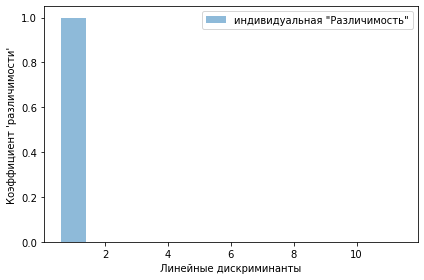

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y = dz["Transported"]
X = dz[features]
X_std = sc.fit_transform(X)

np.set_printoptions(precision = 4)
mean_vecs = []
labels = [-1.0,1.0]
for label in range(len(labels)):
    mean_vecs.append(np.mean(X_std[y == labels[label]],axis = 0))
    print('MV %s: %s\n'%(label,mean_vecs[label-1]))

d = len(features)
S_W = np.zeros((d,d))
for label , mv in zip(labels , mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_std[y == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
#print ('Матрица раcсеяния внутри классов: %sx%s'%(S_W.shape[0], S_W.shape[1]))

S_W = np.zeros((d,d))
for label,mv in zip(labels, mean_vecs):
    class_scatter = np.cov(X_std[y==label].T)
    S_W += class_scatter
#print('Масштабированная матрица рассеяния внутри классов: %sx%s' % (S_W.shape[0], S_W.shape[1]) )

mean_overall = np.mean(X_std, axis= 0)
S_B = np.zeros((d,d))
for i , mean_vec in enumerate(mean_vecs):
    n = X_std[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B +=n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
#print('Матрица рассеяния между классами: %sx%s'%(S_B.shape[0],S_B.shape[1]))

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs=sorted(eigen_pairs, key = lambda k: k[0], reverse = True)

print('Собственные значения в порядке убывания:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted (eigen_vals.real, reverse = True)]
cum_discr = np.cumsum(discr)
size = len(features)+1
plt.bar(range(1,size),discr, alpha = 0.5, align = 'center',label = 'индивидуальная "Различимость"')
plt.ylabel("Коэффициент 'различимости'")
plt.xlabel('Линейные дискриминанты')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [6]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real, eigen_pairs[1][1][:,np.newaxis].real))
print('Матрица W:\n',w)

Матрица W:
 [[ 1.9009e-02  1.2147e-02]
 [-3.4568e-02 -6.8738e-01]
 [-4.0788e-01 -3.4099e-01]
 [ 3.9736e-01 -1.3029e-01]
 [ 2.6689e-01 -2.2296e-01]
 [-5.2272e-01 -1.7862e-01]
 [-4.9192e-01 -3.2364e-01]
 [-1.8578e-01  1.1403e-04]
 [-1.1407e-03  3.4395e-02]
 [ 2.3044e-01 -4.1813e-01]
 [-1.0751e-02 -1.7815e-01]]


<function matplotlib.pyplot.show(close=None, block=None)>

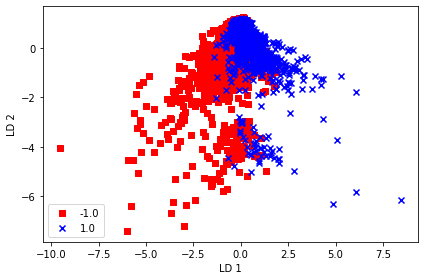

In [7]:
X_lda = X_std.dot(w)

colors = ['r','b']
markers = ['s','x']
for l,c,m in zip(np.unique(y),colors, markers):
    plt.scatter(X_lda[y == l, 0],X_lda[y == l, 1],c = c, label = l, marker = m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show

0.8594558129075781

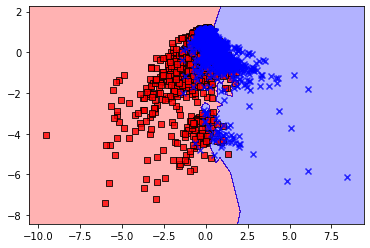

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3, p=2, metric = "minkowski")
ppn_test = knn.fit(X_lda,y)
ds.plot_decision_regions(X_lda,y,classifier = ppn_test,resolution = 0.01)
knn.score(X_lda,y)

In [17]:
mask2 = (df['CryoSleep']==1)|(df['Age']<=12.5)
df_rest = df[mask2]
df_rest.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,3227.000000,3227.000000,3227.000000,3227.0,3227.0,3227.0,3227.0,3227.0,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000
mean,0.888131,24.850635,0.006508,0.0,0.0,0.0,0.0,0.0,0.606446,5.464208,589.664704,1.519058,4.223737
std,0.315254,15.956213,0.080419,0.0,0.0,0.0,0.0,0.0,0.795248,1.954902,488.612792,0.499714,2.410741
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,14.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,169.500000,1.000000,2.000000
50%,1.000000,24.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,6.000000,445.000000,2.000000,4.000000
75%,1.000000,35.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,974.000000,2.000000,7.000000
max,1.000000,78.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1888.000000,2.000000,9.000000


In [18]:
df_rest.drop(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


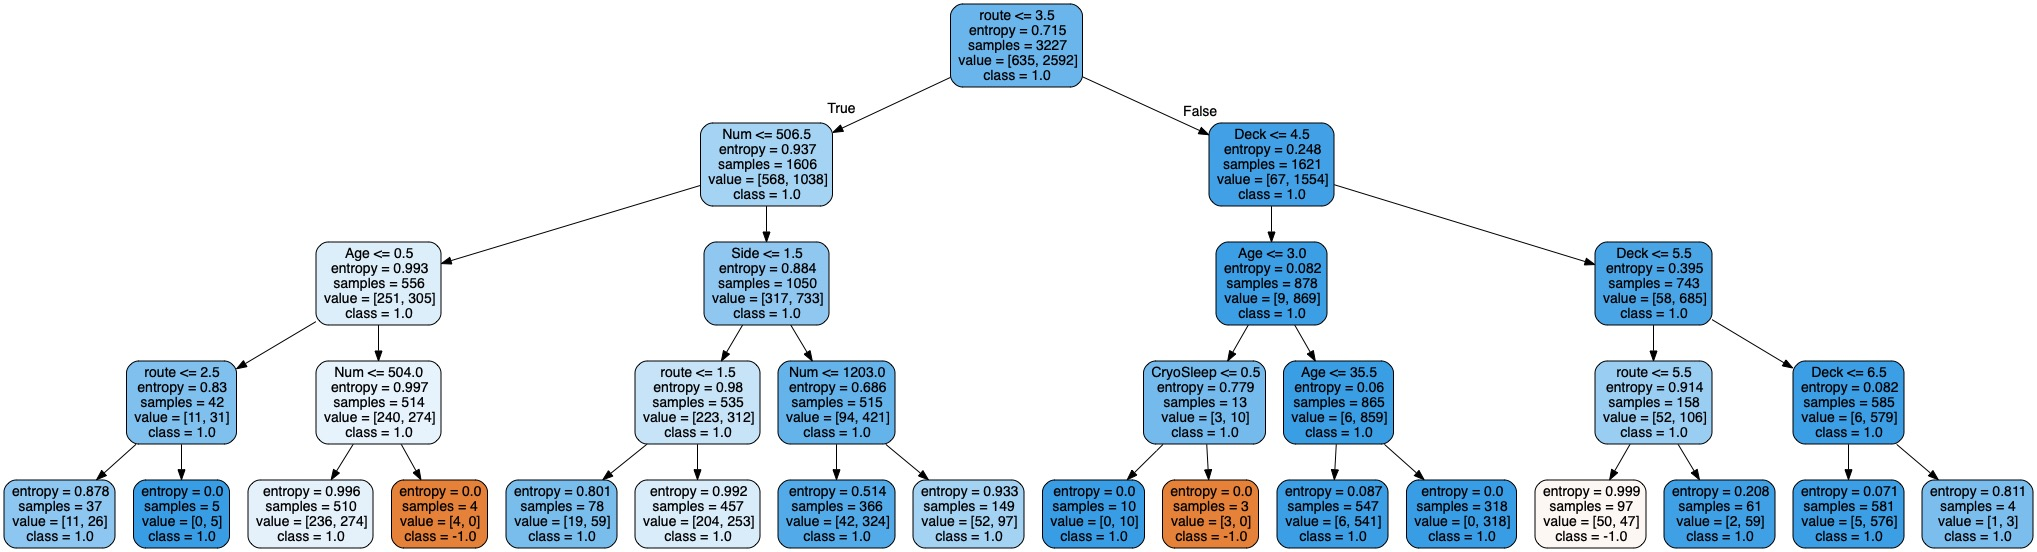

test size:  3227 , total errors in test: 19.37%
index = predicted, columns = factual, in %:
         -1        1
-1  1.76635  1.45646
 1  17.9114  78.8658


In [21]:
features = ['CryoSleep','Age','VIP','Deck','Num','Side','route']
tree = ds.divide_frame(dataf = df_rest,columns = features,teacher_column = "Transported",classifier = 'Tree', criterion_tree = "entropy", depth =4, random_state_sample = 5,random_state_ppn = 2, fraction = 1)

In [23]:
pd.value_counts(df_rest[df_rest["route"]>3.5]["Transported"])

 1.0    1554
-1.0      67
Name: Transported, dtype: int64

if "route">3.5 and ('CryoSleep'==1 or 'Age'<=12.5) ==> assign 1

In [24]:
mask3 = ((df['CryoSleep']==1)|(df['Age']<=12.5))&(df['route']<=3.5)
df_final = df[mask3]

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,1606.000000,1606.000000,1606.0,1606.0,1606.0,1606.0,1606.0,1606.0,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000
mean,0.839352,20.279577,0.0,0.0,0.0,0.0,0.0,0.0,0.292653,6.947073,734.965131,1.504359,2.058531
std,0.367320,15.252832,0.0,0.0,0.0,0.0,0.0,0.0,0.956517,0.340881,442.836016,0.500137,0.625770
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,7.000000,342.500000,1.000000,2.000000
50%,1.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,729.500000,2.000000,2.000000
75%,1.000000,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1092.000000,2.000000,2.000000
max,1.000000,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1808.000000,2.000000,3.000000


In [26]:
df_final.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [27]:
df_final.describe()

,CryoSleep,Age,Transported,Deck,Num,Side,route
count,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000
mean,0.839352,20.279577,0.292653,6.947073,734.965131,1.504359,2.058531
std,0.367320,15.252832,0.956517,0.340881,442.836016,0.500137,0.625770
min,0.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,-1.000000,7.000000,342.500000,1.000000,2.000000
50%,1.000000,18.000000,1.000000,7.000000,729.500000,2.000000,2.000000
75%,1.000000,29.000000,1.000000,7.000000,1092.000000,2.000000,2.000000
max,1.000000,78.000000,1.000000,7.000000,1808.000000,2.000000,3.000000


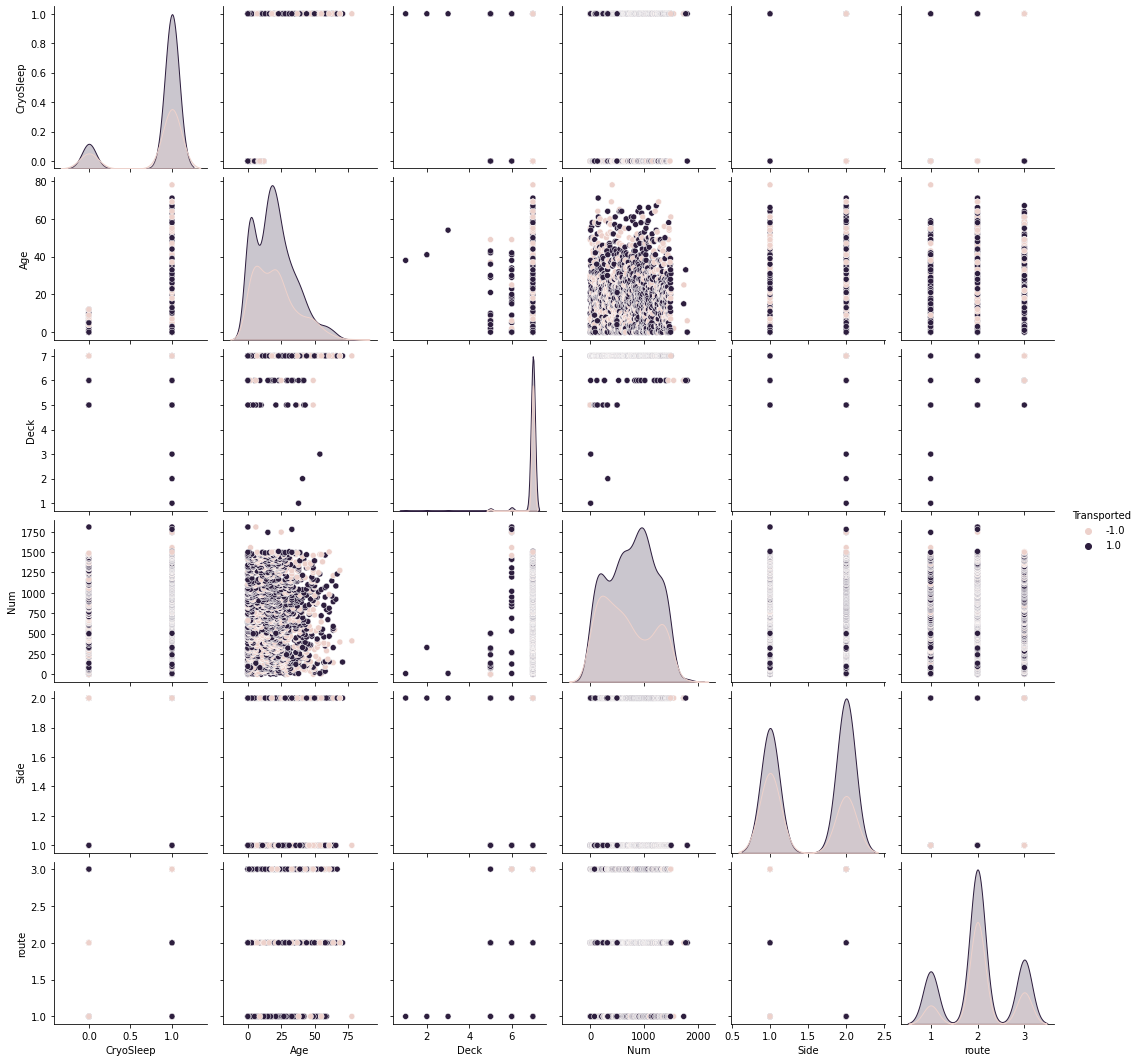

In [28]:
sb.pairplot(df_final,hue = "Transported")

In [29]:
df_final.head()

,CryoSleep,Age,Transported,Deck,Num,Side,route
7,1.0,28.0,1.0,7.0,0.0,2.0,2.0
17,0.0,0.0,1.0,7.0,0.0,1.0,2.0
19,1.0,1.0,-1.0,5.0,0.0,2.0,2.0
20,1.0,49.0,-1.0,5.0,0.0,2.0,1.0
21,1.0,29.0,-1.0,5.0,0.0,2.0,1.0


MV 0: [ 0.0215  0.0623 -0.1321 -0.1777  0.0443]

MV 1: [ 0.0215  0.0623 -0.1321 -0.1777  0.0443]

Собственные значения в порядке убывания:

31.519078787961856
7.746396247628686e-16
7.746396247628686e-16
3.0945949218242333e-16
0.0


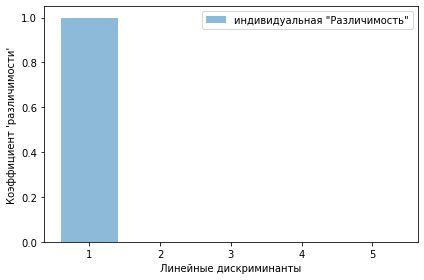

In [31]:
features = ['Age','Deck','Num','Side','route']

sc = StandardScaler()
y = df_final["Transported"]
X = df_final[features]
X_std = sc.fit_transform(X)

np.set_printoptions(precision = 4)
mean_vecs = []
labels = [-1.0,1.0]
for label in range(len(labels)):
    mean_vecs.append(np.mean(X_std[y == labels[label]],axis = 0))
    print('MV %s: %s\n'%(label,mean_vecs[label-1]))

d = len(features)
S_W = np.zeros((d,d))
for label , mv in zip(labels , mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_std[y == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
#print ('Матрица раcсеяния внутри классов: %sx%s'%(S_W.shape[0], S_W.shape[1]))

S_W = np.zeros((d,d))
for label,mv in zip(labels, mean_vecs):
    class_scatter = np.cov(X_std[y==label].T)
    S_W += class_scatter
#print('Масштабированная матрица рассеяния внутри классов: %sx%s' % (S_W.shape[0], S_W.shape[1]) )

mean_overall = np.mean(X_std, axis= 0)
S_B = np.zeros((d,d))
for i , mean_vec in enumerate(mean_vecs):
    n = X_std[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B +=n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
#print('Матрица рассеяния между классами: %sx%s'%(S_B.shape[0],S_B.shape[1]))

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs=sorted(eigen_pairs, key = lambda k: k[0], reverse = True)

print('Собственные значения в порядке убывания:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted (eigen_vals.real, reverse = True)]
cum_discr = np.cumsum(discr)
size = len(features)+1
plt.bar(range(1,size),discr, alpha = 0.5, align = 'center',label = 'индивидуальная "Различимость"')
plt.ylabel("Коэффициент 'различимости'")
plt.xlabel('Линейные дискриминанты')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [33]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real, eigen_pairs[1][1][:,np.newaxis].real))
print('Матрица W:\n',w)

Матрица W:
 [[-0.0456  0.0653]
 [-0.3043  0.6899]
 [ 0.593   0.5734]
 [ 0.7358 -0.2098]
 [-0.1105 -0.1347]]


<function matplotlib.pyplot.show(close=None, block=None)>

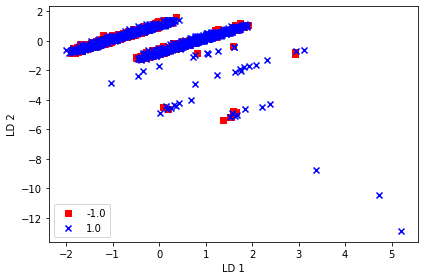

In [34]:
X_lda = X_std.dot(w)
colors = ['r','b']
markers = ['s','x']
for l,c,m in zip(np.unique(y),colors, markers):
    plt.scatter(X_lda[y == l, 0],X_lda[y == l, 1],c = c, label = l, marker = m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show

0.6463262764632628

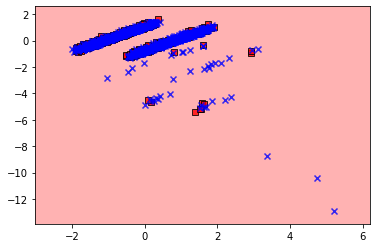

In [35]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C =1)
ppn_test = svm.fit(X_lda,y)
ds.plot_decision_regions(X_lda,y,classifier = ppn_test,resolution = 0.01)
svm.score(X_lda,y)

0.7198007471980075

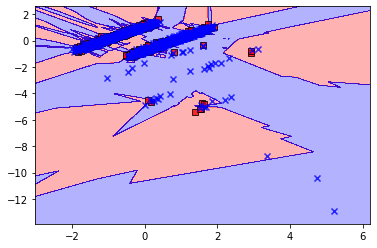

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 4, p=2, metric = "minkowski")
ppn_test = knn.fit(X_lda,y)
ds.plot_decision_regions(X_lda,y,classifier = ppn_test,resolution = 0.01)
knn.score(X_lda,y)